# Popularity Approach
**Goal:** A study of how the popularity approval interacts with the sentiment measure in the speechs <br>
* Download a realible source of popularity data ✔️ <br>
We decided to use https://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html since it is a compilation of various popularity polls.
* Plot populatity over time vs sentiment over time (presidency speeches only) ✔️
* Plot popularity with the weighted score ✔️

## Load data

In [1]:
# Libraries

from urllib import request
from pathlib import Path
from plotly.subplots import make_subplots
import json
import os
import plotly
import sys
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Basic paths
src_path = str(Path.cwd().parent / "src")
sys.path.append(src_path)


project_path = Path().resolve().parent
csv_path = project_path / "speeches_csv"

## Download polls and save a readable table

In [2]:
# Download the source

download_path = project_path / "sentiment_analysis"  # To change later

# Define the remote file to retrieve
remote_url = 'https://www.realclearpolitics.com/epolls/json/1044_historical.js?1653863439874&callback=return_json'
# Define the local filename to save data
local_file = download_path / 'obama-job-approval-ratings.txt'
# Download remote and save locally
request.urlretrieve(remote_url, local_file)

(PosixPath('/Users/serenekim/MDA _Project/mda-kuwait/sentiment_analysis/obama-job-approval-ratings.txt'),
 <http.client.HTTPMessage at 0x7fb7240cb880>)

In [3]:
# Edit the downloaded file useful table, save it and delete extra files

with open(download_path / 'obama-job-approval-ratings.txt','r') as f:
    s_temp = f.read()
    s_temp = s_temp.split("(")
    s_temp = s_temp[1:]
    s_temp = s_temp[0]
    s_temp = s_temp.split("state")
    s_temp = s_temp[0]
    s_temp = s_temp[:-14]+"}}"
    d_temp = eval(s_temp)

approve = []
disapprove = []
date = []

for i in range(len(d_temp['poll']["rcp_avg"])):
    approve.append(float(d_temp['poll']["rcp_avg"][i]["candidate"][0]["value"]))
    disapprove.append(float(d_temp['poll']["rcp_avg"][i]["candidate"][1]["value"]))
    date.append(pd.to_datetime(d_temp['poll']["rcp_avg"][i]["date"], utc=True))

df_ppl = pd.DataFrame({"date": date, "Approve": approve, "Disapprove": disapprove})
df_ppl["date"] = df_ppl["date"].dt.strftime('%Y-%m-%d')
df_ppl["date"] = pd.to_datetime(df_ppl["date"])
df_ppl = df_ppl.sort_values(by=["date"], ascending=True)
df_ppl.to_csv(download_path / 'obama-job-approval-ratings.txt', index=False)

## Open tables and treat them if necessary

In [4]:
# Open the popularity data 

df_ppl = pd.read_csv(download_path / 'obama-job-approval-ratings.txt')
df_ppl = df_ppl.sort_values("date")
df_ppl.head()

date  Approve  Disapprove
0  2009-01-27     63.3        20.0
1  2009-01-28     63.3        20.0
2  2009-01-29     63.5        19.3
3  2009-01-30     63.5        19.3
4  2009-01-31     61.8        19.4

In [5]:
# Open the sentiment data and filter for presidential speeches

df_sa = pd.read_csv(download_path / 'results_sa_all.txt', infer_datetime_format = True, parse_dates = ["date"])

df_sa["date"] = pd.to_datetime(df_sa["date"])
df_sa = df_sa.sort_values("date")
df_sa = df_sa[df_sa["date"] >= "2009-01-27"]
df_sa.head()

title       date  stanza  \
201  Economic_Crisis_and_Executive_Compensation_Sal... 2009-02-04  -0.226   
284                               Lincoln_Bicentennial 2009-02-12  -0.207   
47                            State_of_the_Nation_2009 2009-02-24  -0.246   
276                              Iraq_War_Camp_Lejeune 2009-02-27  -0.028   
275                       Hispanic_Chamber_of_Commerce 2009-03-10  -0.132   

     textblob  vader  subjectivity  
201     0.122  0.950         0.409  
284     0.113  0.592         0.466  
47      0.101  1.000         0.433  
276     0.170  1.000         0.438  
275     0.174  1.000         0.464

In [6]:
# Load the most negative speechs

df_temp = df_sa
weighted = df_temp['subjectivity']*df_temp['vader']
df_temp['weighted'] = weighted
exweight = df_temp[df_temp['weighted'] < -0.4] 
print("The number of extreme cases is ", len(exweight))
exweight[['title', 'vader', 'subjectivity', 'weighted']]
exweight

The number of extreme cases is  13


title       date  stanza  textblob  \
23               Gun_Violence_Exec_Order_23 2013-01-16  -0.233     0.139   
142                     Gun_Violence_Denver 2013-04-03  -0.203     0.128   
278              Syria_Speech_to_the_Nation 2013-09-10  -0.254     0.018   
114    United_Nations_Security_Council_2014 2014-09-24  -0.055     0.096   
191    United_Nations_General_Assembly_2014 2014-09-24  -0.216     0.082   
104            Gun_Violence_Reduction_Steps 2015-01-05  -0.125     0.131   
3        Umpqua_Community_College_Shootings 2015-10-01  -0.250     0.061   
261  Barack_Obama_-_Weekly_Address_01-01-16 2016-01-01  -0.068     0.080   
184     Barack_Obama_-_ISIL_Update_02-25-16 2016-02-25  -0.188     0.076   
337        Hiroshima_Peace_Memorial_Address 2016-05-27  -0.146     0.122   
172                 ISIL_Briefing_June_2016 2016-06-14  -0.203     0.118   
182                       Orlando_Community 2016-07-16  -0.030     0.178   
195       On_Counterterrorism_Approach_2016 2016-12-06  -0.232     0.086   

     vader  subjectivity  weighted  
23  -0.992         0.505 -0.500960  
142 -0.998         0.493 -0.492014  
278 -1.000         0.405 -0.405000  
114 -0.999         0.423 -0.422577  
191 -0.992         0.469 -0.465248  
104 -0.997         0.486 -0.484542  
3   -0.998         0.435 -0.434130  
261 -0.971         0.425 -0.412675  
184 -0.999         0.429 -0.428571  
337 -0.998         0.522 -0.520956  
172 -1.000         0.466 -0.466000  
182 -0.919         0.538 -0.494422  
195 -1.000         0.430 -0.430000

## Plots

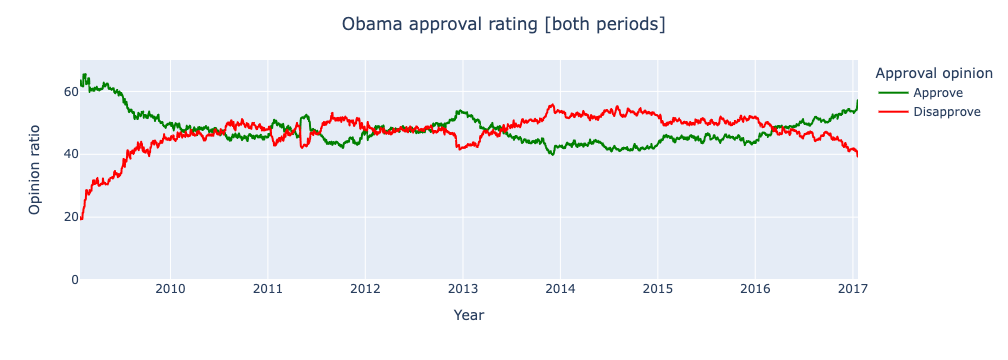

In [7]:
# Plot obama ratings

fig = px.line(df_ppl, x="date", y=["Approve","Disapprove"], 
              color_discrete_sequence=["green", "red"])
fig.update_layout(title = {"text":"Obama approval rating [both periods]", "x":0.5},
                  legend_title = "Approval opinion",
                  xaxis_title = "Year",
                  yaxis_title = "Opinion ratio",
                  yaxis_range=[0,70])

fig.show()

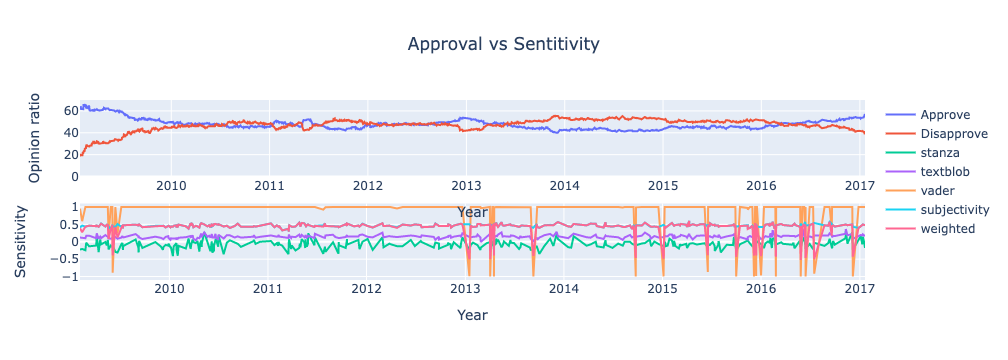

In [8]:
# Plot sentiment plus ratings (separated)

# Create figure with secondary y-axis
all_fig = make_subplots(rows=2, cols=1)

# Add popularity lines
for col in df_ppl.columns[1:]:
    all_fig.add_trace(go.Scatter(x=df_ppl["date"],
                      y=df_ppl[col], name=col),
                      row=1, col=1)

# Add sensitivity lines
for col in df_sa.columns[2:]:
    all_fig.add_trace(go.Scatter(x=df_sa["date"],
                      y=df_sa[col], name=col),
                      row=2,col=1)

# Add figure title
all_fig.update_layout(#height=600, width=1450,
    title = {"text":"Approval vs Sentitivity", "x":0.5})

# Set x-axis title
all_fig.update_xaxes(title_text="Year")
all_fig.update_yaxes(title_text="Opinion ratio",range=[0,70], row=1, col=1)
all_fig.update_yaxes(title_text="Sensitivity",range=[-1.1,1.1], row=2, col=1)

all_fig.show()

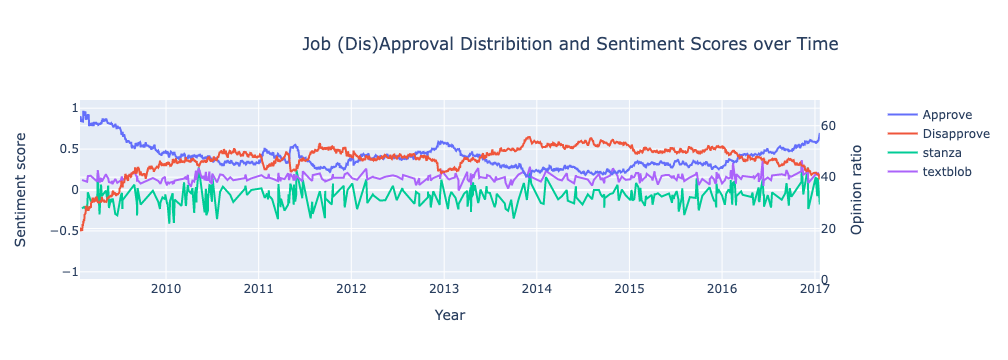

In [9]:
# Plot sentiment plus ratings (together)


# Create figure with secondary y-axis
al2_fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add popularity lines
for col in df_ppl.columns[1:]:
    al2_fig.add_trace(go.Scatter(x=df_ppl["date"],
                      y=df_ppl[col], name=col),
                      secondary_y=True,)

# Add sensitivity lines
for col in df_sa.columns[2:]:
    if col == 'stanza' or  col == 'textblob':
        al2_fig.add_trace(go.Scatter(x=df_sa["date"],
                          y=df_sa[col], name=col),
                          secondary_y=False,)

# Add figure title
al2_fig.update_layout(#height=600, width=1450,
    title = {"text":"Job (Dis)Approval Distribition and Sentiment Scores over Time", "x":0.3})

# Set x-axis title
al2_fig.update_xaxes(title_text="Year")
al2_fig.update_yaxes(title_text="Opinion ratio",range=[0,70], secondary_y=True)
al2_fig.update_yaxes(title_text="Sentiment score",range=[-1.1,1.1], secondary_y=False)
al2_fig.show()
al2_fig.write_image("ja_stanza_textblob.png")

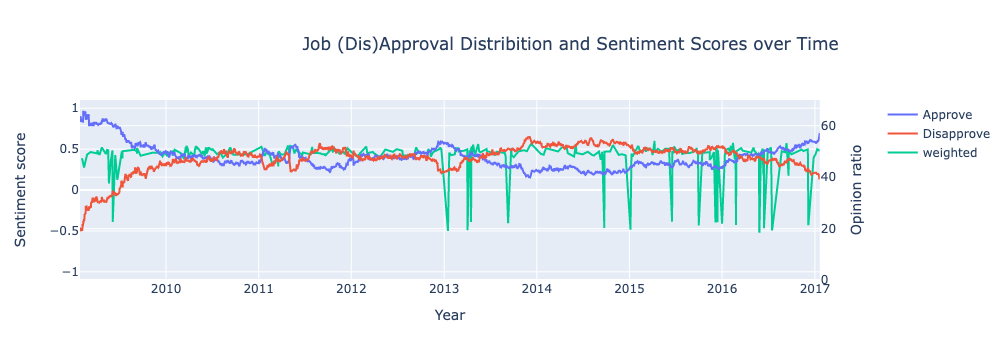

In [10]:
# Plot sentiment plus ratings (together)

# Create figure with secondary y-axis
alt_fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add popularity lines
for col in df_ppl.columns[1:]:
    alt_fig.add_trace(go.Scatter(x=df_ppl["date"],
                      y=df_ppl[col], name=col),
                      secondary_y=True,)

# Add sensitivity lines
for col in df_sa.columns[2:]:
    if col == 'weighted':
        alt_fig.add_trace(go.Scatter(x=df_sa["date"],
                          y=df_sa[col], name=col),
                          secondary_y=False,)

# Add figure title
alt_fig.update_layout(#height=600, width=1450,
    title = {"text":"Job (Dis)Approval Distribition and Sentiment Scores over Time", "x":0.3})

# Set x-axis title
alt_fig.update_xaxes(title_text="Year")
alt_fig.update_yaxes(title_text="Opinion ratio",range=[0,70], secondary_y=True)
alt_fig.update_yaxes(title_text="Sentiment score",range=[-1.1,1.1], secondary_y=False)
alt_fig.show()
alt_fig.write_image("ja_weighted.png")

## Correlation

Note that in the Mixed_Model Notebook, `Disapprove` appears to be slightly significant (p=0.010) to explain sentiment (sentiment per sentence). We draw correlation plots in order to see whether the lack of relations between the (dis)approval and sentiment distributions that we saw from the line graphs above, resonates statistically. 

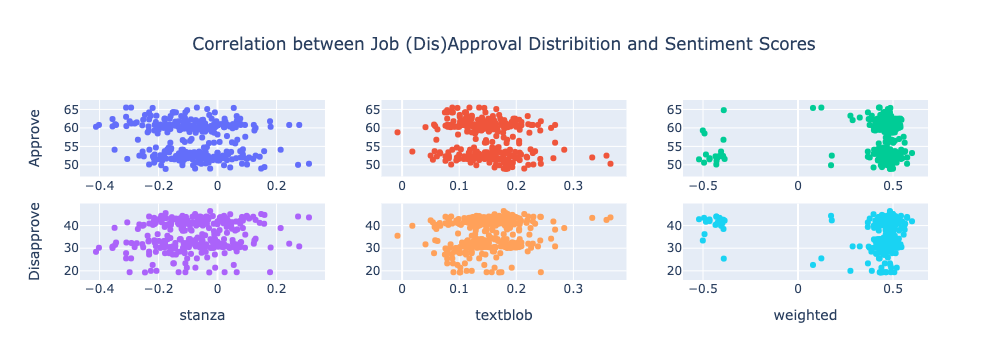

In [11]:
# Correlation plots

# Create figure with secondary y-axis
cor_fig = make_subplots(rows=2, cols=3)
rows = df_ppl.columns[1:]
cols = [df_sa.columns[2], df_sa.columns[3], df_sa.columns[-1]]

for r in range(len(rows)):
    for c in range(len(cols)):
        cor_fig.add_trace(go.Scatter(x=df_sa[cols[c]],
                          y=df_ppl[rows[r]], mode='markers'), row=(r+1), col=(c+1))

for r in range(len(rows)):
    cor_fig.update_yaxes(title_text=rows[r], row=r+1, col=1)

for c in range(len(cols)):
    cor_fig.update_xaxes(title_text=cols[c], row=2, col=c+1)
        

# Add figure title
cor_fig.update_layout(#height=600, width=1450,
    title = {"text":"Correlation between Job (Dis)Approval Distribition and Sentiment Scores", "x":0.5})
cor_fig.update_layout(showlegend=False)
cor_fig.show()

cor_fig.write_image("correlationsScoreJA.png")

# Gun Deaths vs. Sentiment

When we look at the extreme values, it is remarkable that there are many speeches of which their titles contain terms, `violence`, and `shooting`. Therefore, we compare the number of gun deaths per month in the US and the sentiment socres across the dates. <br>
Gun Deaths data from https://injuryfacts.nsc.org/home-and-community/safety-topics/guns/data-details/

In [44]:
gun_deaths = pd.read_csv(download_path / 'gun_deaths.csv')
gun_deaths_wide = gun_deaths.pivot(index="Year", columns="Intent", values = "Total")
gun_deaths_wide['Year'] = gun_deaths_wide.index
gun_deaths_wide

Intent  Assault  Legal intervention  Preventable/accidental  Suicide  \
Year                                                                   
1999    10828.0               299.0                   824.0  16599.0   
2000    10801.0               270.0                   776.0  16586.0   
2001    11348.0               323.0                   802.0  16869.0   
2002    11829.0               300.0                   762.0  17108.0   
2003    11920.0               347.0                   730.0  16907.0   
2004    11624.0               311.0                   649.0  16750.0   
2005    12352.0               330.0                   789.0  17002.0   
2006    12791.0               360.0                   642.0  16883.0   
2007    12632.0               351.0                   613.0  17352.0   
2008    12179.0               326.0                   592.0  18223.0   
2009    11493.0               333.0                   554.0  18735.0   
2010    11078.0               344.0                   606.0  19392.0   
2011    11068.0               454.0                   591.0  19990.0   
2012    11622.0               471.0                   548.0  20666.0   
2013    11207.0               467.0                   505.0  21175.0   
2014    11008.0               464.0                   461.0  21386.0   
2015    12974.0               484.0                   489.0  22018.0   
2016    14415.0               510.0                   495.0  22938.0   
2017    14542.0               553.0                   486.0  23854.0   
2018    13958.0               539.0                   458.0  24432.0   
2019    14414.0                 NaN                   486.0  23941.0   
2020    19384.0                 NaN                   535.0  24292.0   

Intent  Total - all intents  Undetermined  Year  
Year                                             
1999                28874.0         324.0  1999  
2000                28663.0         230.0  2000  
2001                29573.0         231.0  2001  
2002                30242.0         243.0  2002  
2003                30136.0         232.0  2003  
2004                29569.0         235.0  2004  
2005                30694.0         221.0  2005  
2006                30896.0         220.0  2006  
2007                31224.0         276.0  2007  
2008                31593.0         273.0  2008  
2009                31347.0         232.0  2009  
2010                31672.0         252.0  2010  
2011                32351.0         248.0  2011  
2012                33563.0         256.0  2012  
2013                33635.0         281.0  2013  
2014                33594.0         275.0  2014  
2015                36247.0         282.0  2015  
2016                38658.0         300.0  2016  
2017                39773.0         338.0  2017  
2018                39740.0         353.0  2018  
2019                39707.0           NaN  2019  
2020                45222.0           NaN  2020

In [45]:
gun_deaths_wide = gun_deaths_wide.loc[(gun_deaths_wide['Year'] > 2008) & (gun_deaths_wide['Year'] < 2018)]
gun_deaths_wide

Intent  Assault  Legal intervention  Preventable/accidental  Suicide  \
Year                                                                   
2009    11493.0               333.0                   554.0  18735.0   
2010    11078.0               344.0                   606.0  19392.0   
2011    11068.0               454.0                   591.0  19990.0   
2012    11622.0               471.0                   548.0  20666.0   
2013    11207.0               467.0                   505.0  21175.0   
2014    11008.0               464.0                   461.0  21386.0   
2015    12974.0               484.0                   489.0  22018.0   
2016    14415.0               510.0                   495.0  22938.0   
2017    14542.0               553.0                   486.0  23854.0   

Intent  Total - all intents  Undetermined  Year  
Year                                             
2009                31347.0         232.0  2009  
2010                31672.0         252.0  2010  
2011                32351.0         248.0  2011  
2012                33563.0         256.0  2012  
2013                33635.0         281.0  2013  
2014                33594.0         275.0  2014  
2015                36247.0         282.0  2015  
2016                38658.0         300.0  2016  
2017                39773.0         338.0  2017

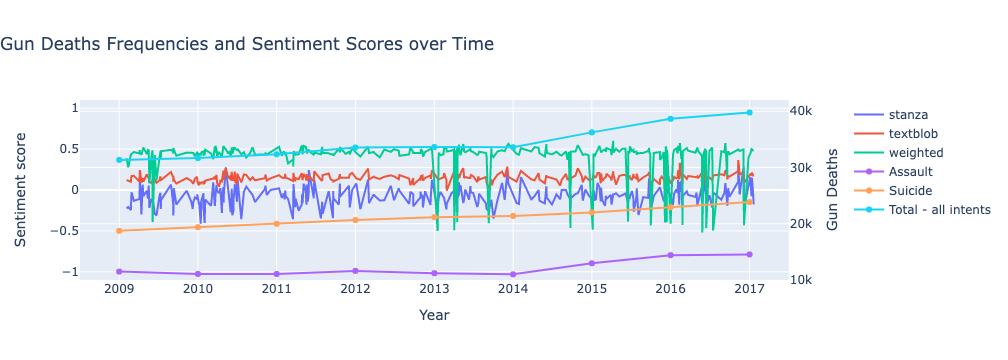

In [55]:
# Create figure with secondary y-axis
al2_fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add sensitivity lines
for col in df_sa.columns[2:]:
    if col == 'stanza' or  col == 'textblob' or col == 'weighted' :
        al2_fig.add_trace(go.Scatter(x=df_sa["date"],
                          y=df_sa[col], name=col),
                          secondary_y=False,)
# Add popularity lines
for col in gun_deaths_wide.columns[0:6]:
    if col == 'Assault' or  col == 'Suicide' or col == 'Total - all intents' :
        al2_fig.add_trace(go.Scatter(x=gun_deaths_wide["Year"],
                      y=gun_deaths_wide[col], name=col),
                      secondary_y=True,)


# Add figure title
al2_fig.update_layout(#height=600, width=1450,
    title = {"text":"Gun Deaths Frequencies and Sentiment Scores over Time", "x":0})

# Set x-axis title
al2_fig.update_xaxes(title_text="Year")
al2_fig.update_yaxes(title_text="Gun Deaths", range=[10000, 42000], secondary_y=True)
al2_fig.update_yaxes(title_text="Sentiment score",range=[-1.1,1.1], secondary_y=False)
al2_fig.show()


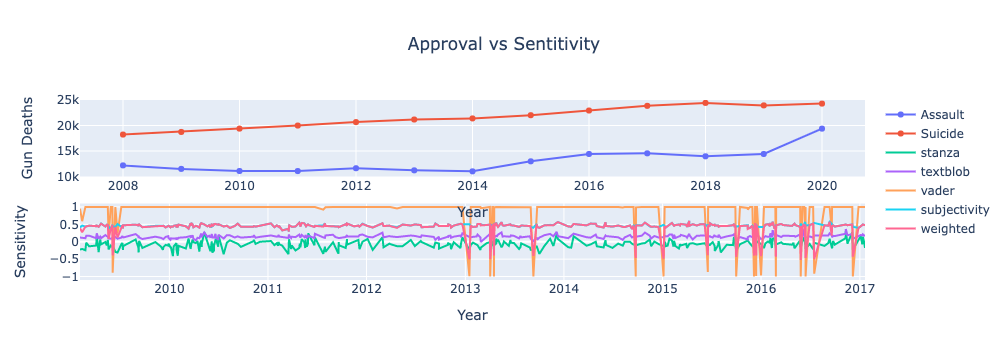

In [24]:
# Plot sentiment plus ratings (separated)

# Create figure with secondary y-axis
all_fig = make_subplots(rows=2, cols=1)

# Add popularity lines
for col in gun_deaths_wide.columns[0:6]:
    if col == 'Assault' or  col == 'Suicide':
        all_fig.add_trace(go.Scatter(x=gun_deaths_wide["Year"],
                      y=gun_deaths_wide[col], name=col), row=1, col=1)
        
        
#         # Add popularity lines
# for col in df_ppl.columns[1:]:
#     all_fig.add_trace(go.Scatter(x=df_ppl["date"],
#                       y=df_ppl[col], name=col),
#                       row=1, col=1)

# Add sensitivity lines
for col in df_sa.columns[2:]:
    all_fig.add_trace(go.Scatter(x=df_sa["date"],
                      y=df_sa[col], name=col),
                      row=2,col=1)

# Add figure title
all_fig.update_layout(#height=600, width=1450,
    title = {"text":"Approval vs Sentitivity", "x":0.5})

# Set x-axis title
all_fig.update_xaxes(title_text="Year")
all_fig.update_yaxes(title_text="Gun Deaths",range=[10000,25000], row=1, col=1)
all_fig.update_yaxes(title_text="Sensitivity",range=[-1.1,1.1], row=2, col=1)

all_fig.show()